# CI Portfolio Project 5 - Filter Maintenance Predictor 2022
## **ML Model - Predict Remaining Useful Life (RUL)**

## Objectives

Answer [Business Requirement 1](https://github.com/roeszler/filter-maintenance-predictor/blob/main/README.md#business-requirements) :
*   Fit and evaluate a **regression model** to predict the Remaining Useful Life of a replaceable part
*   Fit and evaluate a **classification model** to predict the Remaining Useful Life of a replaceable part should the regressor not perform well.

## Inputs

Data cleaning:
* outputs/datasets/cleaned/dfCleanTotal.csv

## Outputs

* Train set (features and target)
* Test set (features and target)
* Validation set (features and target)
* ML pipeline to predict RUL
* A map of the labels
* Feature Importance Plot



---

### Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("Current directory set to new location")

Current directory set to new location


In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/filter-maintenance-predictor'

---

## The major steps in this Regressor Pipeline

<details>
<summary style="font-size: 0.9rem;"><strong>1. ML Pipeline: Regressor</strong> (Dropdown List)</summary>

* Create Regressor Pipeline
* Split the train set
* Grid Search CV SKLearn
    * Use standard hyperparameters to find most suitable algorithm
    * Extensive search on most suitable algorithm to find the best hyperparameter configuration
* Assess Feature Performance
* Evaluate Regressor
* Create Train, Test, Validation Sets
</details></br>


<details>
<summary style="font-size: 0.9rem;"><strong>2. ML Pipeline: Regressor + Principal Component Analysis</strong> (PCA)</summary>

* Prepare the Data for the Pipeline
* Create Regressor + PCA Pipeline
* Split the train and validation sets
* Grid Search CV SKLearn
    * Use standard hyperparameters to find most suitable algorithm
    * Do an extensive search on most suitable algorithm to find the best hyperparameter configuration
* Assess Feature Performance
* Evaluate Regressor
* Create Train, Test, Validation Sets
</details></br>

<details>
<summary style="font-size: 0.9rem;"><strong>3. Convert Regression to Classification</strong> (Optionally)</summary>

* Convert numerical target to bins, and check if it is balanced
* Rewrite Pipeline for ML Modelling
* Load Algorithms For Classification
* Split the Train Test sets:
* Grid Search CV SKLearn:
    * Use standard hyper parameters to find most suitable model
    * Grid Search CV
    * Check Result
* Do an extensive search on the most suitable model to find the best hyperparameter configuration.
    * Define Model Parameters
    * Extensive Grid Search CV                             
    * Check Results
    * Check Best Model
    * Parameters for best model
    * Define the best clf_pipeline
* Assess Feature Importance
* Evaluate Classifier on Train and Test Sets
    * Custom Function
    * List that relates the classes and tenure interval
</details></br>

<details><summary style="font-size: 0.9rem;"><strong>4. Decide which pipeline to use</strong></summary></details></br>

<details>
<summary style="font-size: 0.9rem;"><strong>5. Refit with the best features</strong></summary>

* Rewrite Pipeline
* Split Train Test Set with only best features
* Subset best features
* Grid Search CV SKLearn
* Best Parameters
    * Manually
* Grid Search CV
* Check Results
* Check Best Model
* Define the best pipeline
</details></br>

<details><summary style="font-size: 0.9rem;"><strong>6. Assess Feature Importance</strong></summary></details></br>

<details><summary style="font-size: 0.9rem;"><strong>7. Push Files to Repo</strong></summary></details>

<!-- Modelling:
The hypothesis part of the process where you will find out whether you can answer the question.
* Identify what techniques to use.
* Split your data into train, validate and test sets.
* Build and train the models with the train data set.
* Validate Models and hyper-parameter : Trial different machine learning methods and models with the validation data set.
* Poor Results - return to data preparation for feature engineering
* Successful hypothesis - where the inputs from the data set are mapped to the output target / label appropriately to evaluate.

5. Evaluation:
Where you test whether the model can predict unseen data.
* Test Dataset
* Choose the model that meets the business success criteria best.
* Review and document the work that you have done.
* If your project meets the success metrics you defined with your customer?
- Ready to deploy. -->

---

### Load Cleaned Data
Target variable for regressor, remove from classifier and drop other variables not required

In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb

df_total = pd.read_csv(f'outputs/datasets/transformed/dfTransformedTotal.csv') # data with all negative log_EWM values removed
df_total_model = (pd.read_csv('outputs/datasets/transformed/dfTransformedTotal.csv')
        .drop(labels=['4point_EWM', 'change_DP', 'change_EWM'], axis=1)
    )
df_train_even_dist = (pd.read_csv(f'outputs/datasets/transformed/dfTransformedTrain.csv')
        .drop(labels=['4point_EWM', 'change_DP', 'change_EWM', 'std_DP', 'median_DP', 'bin_size'], axis=1)
    )
print(df_total.shape, '= df_total')
print(df_total_model.shape, '= df_total_model')
print(df_train_even_dist.shape, '= df_train_even_dist')
df_total

(69686, 15) = df_total
(69686, 12) = df_total_model
(20931, 12) = df_train_even_dist


,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.000000,0.327257,0.242340,13.328682,44.9,99.74
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.000000,0.196354,0.242340,13.571021,44.9,99.74
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.000000,0.117813,0.242340,13.813361,44.9,99.74
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,NaN,1.808449,0.794067,0.242340,14.055701,44.9,99.44
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,NaN,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
69682,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
69683,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
69684,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


In [5]:
df_total_model

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.242340,13.328682,44.9,99.74
1,1,1.537182,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.242340,13.571021,44.9,99.74
2,1,1.537182,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.242340,13.813361,44.9,99.74
3,1,3.345631,0.767573,54.780562,5.8,236.428943,1.025,NaN,0.242340,14.055701,44.9,99.44
4,1,5.244502,1.220983,54.574466,5.9,236.428943,1.025,NaN,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
69682,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
69683,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
69684,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


---

# ML Pipeline : Regressor
## Create Regressor Pipeline
### Set the Transformations
* Smart correlation
* feat_scaling
* feat_selection
* Modelling
* Model as variable

Note: Numerical Transformation not required as data supplied as integers

In [6]:
df_total_model

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.242340,13.328682,44.9,99.74
1,1,1.537182,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.242340,13.571021,44.9,99.74
2,1,1.537182,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.242340,13.813361,44.9,99.74
3,1,3.345631,0.767573,54.780562,5.8,236.428943,1.025,NaN,0.242340,14.055701,44.9,99.44
4,1,5.244502,1.220983,54.574466,5.9,236.428943,1.025,NaN,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
69682,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
69683,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
69684,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


## Split the data into Train, Test, Validate

Data is discrete however in bins, so:
#### Define Cleaned **Train** & **Test** Datasets

In [7]:
df_total_model

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.242340,13.328682,44.9,99.74
1,1,1.537182,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.242340,13.571021,44.9,99.74
2,1,1.537182,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.242340,13.813361,44.9,99.74
3,1,3.345631,0.767573,54.780562,5.8,236.428943,1.025,NaN,0.242340,14.055701,44.9,99.44
4,1,5.244502,1.220983,54.574466,5.9,236.428943,1.025,NaN,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
69682,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
69683,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
69684,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


In [8]:
n = df_total_model['Data_No'].iloc[0:len(df_total)]
df_test = df_total_model[n > 50].reset_index(drop=True)
df_train = df_train_even_dist # smaller dataset
# df_train = df_total_model[n < 51].reset_index(drop=True) # larger dataset
# df_train = df_train_even_dist.fillna(0)

df_train_model = df_train_even_dist
# df_train_model = df_train_even_dist.fillna(0)
df_train

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,8,4.159433,0.509088,79.771690,0.6,59.107236,0.9,NaN,0.053197,0.319179,179.4,99.31
1,8,6.691262,1.301490,80.820436,0.7,59.107236,0.9,NaN,0.053197,0.372376,179.4,98.88
2,8,9.856047,1.816010,80.605533,0.8,59.107236,0.9,NaN,0.053197,0.425572,179.4,98.36
3,8,12.749570,2.173409,80.639911,0.9,59.107236,0.9,NaN,0.053197,0.478769,179.4,97.88
4,8,14.738860,2.413094,80.786058,1.0,59.107236,0.9,NaN,0.053197,0.531965,179.4,97.54
...,...,...,...,...,...,...,...,...,...,...,...,...
20926,50,359.971800,5.878279,58.721877,59.4,177.321707,1.2,NaN,0.212786,126.394913,59.8,40.00
20927,50,360.785600,5.882293,58.699919,59.5,177.321707,1.2,NaN,0.212786,126.607699,59.8,39.87
20928,50,361.509000,5.885498,58.743820,59.6,177.321707,1.2,NaN,0.212786,126.820485,59.8,39.75
20929,50,362.051500,5.888018,58.601152,59.7,177.321707,1.2,NaN,0.212786,127.033271,59.8,39.66


In [9]:
df_test

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,51,2.622251,0.148056,55.524146,0.4,236.428943,1.025,58.6,0.242340,0.969359,36.6,99.56
1,51,3.888165,0.811380,55.852018,0.5,236.428943,1.025,58.5,0.242340,1.211698,36.6,99.35
2,51,4.521122,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.242340,1.454038,36.6,99.25
3,51,4.521122,1.309382,56.150070,0.7,236.428943,1.025,58.3,0.242340,1.696378,36.6,99.25
4,51,4.521122,1.393959,56.090457,0.8,236.428943,1.025,58.2,0.242340,1.938717,36.6,99.25
...,...,...,...,...,...,...,...,...,...,...,...,...
36357,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
36358,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
36359,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
36360,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


#### Determine **Target** and **Independent** Variables and Extract **Validation** Dataset

As discussed in the readme, this data has been supplied pre-split into **train** and **test** within unique **data bins**. 
We extract random observations from the **test** dataset to create a **validation** set, in a 70:30 split.


In [10]:
df_test

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,51,2.622251,0.148056,55.524146,0.4,236.428943,1.025,58.6,0.242340,0.969359,36.6,99.56
1,51,3.888165,0.811380,55.852018,0.5,236.428943,1.025,58.5,0.242340,1.211698,36.6,99.35
2,51,4.521122,1.150273,56.130203,0.6,236.428943,1.025,58.4,0.242340,1.454038,36.6,99.25
3,51,4.521122,1.309382,56.150070,0.7,236.428943,1.025,58.3,0.242340,1.696378,36.6,99.25
4,51,4.521122,1.393959,56.090457,0.8,236.428943,1.025,58.2,0.242340,1.938717,36.6,99.25
...,...,...,...,...,...,...,...,...,...,...,...,...
36357,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
36358,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
36359,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
36360,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


Review correlations, Drop Features and Split into **70% test** and **30% validate**. 

In [11]:
from sklearn.model_selection import train_test_split
from feature_engine.selection import SmartCorrelatedSelection

corr_sel = SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")
df_engineering = df_test.copy()
corr_sel.fit_transform(df_engineering)

# log_EWM = df_test['log_EWM']
features_to_drop_test = corr_sel.features_to_drop_
features_to_drop_test = [e for e in features_to_drop_test if e not in ('Dust_feed', 'Time', 'RUL', 'mass_g', 'cumulative_mass_g', 'filter_balance')] # prevent these requirements from being removed in V1
# features_to_drop_test = [e for e in features_to_drop_test if e not in ('Dust_feed', 'Time', 'RUL', 'mass_g', 'cumulative_mass_g')] # prevent these requirements from being removed in V1
features_to_drop_test.insert(0, 'Differential_pressure') # include differential pressure to be removed
X = df_test.drop(features_to_drop_test,axis=1)
y = df_test['Differential_pressure'] # define the target variable
# y = df_test['filter_balance'] # define the target variable

X_test, X_validate, y_test, y_validate = train_test_split(X,y,test_size=0.30, random_state=0)

print(X_test.shape, 'X_test')
print(X_validate.shape, 'X_validate')
print(y_test.shape, 'y_test')
print(y_validate.shape, 'y_validate')
print('\nFeatures Suggested to Drop :\n', features_to_drop_test)

(25453, 10) X_test
(10909, 10) X_validate
(25453,) y_test
(10909,) y_validate

Features Suggested to Drop :
 ['Differential_pressure', 'log_EWM']


In [12]:
X_test

,Data_No,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
2168,56,57.383039,10.6,158.492533,1.025,95.8,0.162455,17.220214,71.3,99.25
20305,77,57.690319,37.6,237.738799,1.025,40.6,0.243682,91.624533,60.2,89.63
32959,94,60.006667,15.5,316.985065,0.900,22.7,0.285287,43.934130,24.1,97.23
24724,79,81.686305,213.0,59.107236,1.200,122.2,0.070929,151.078095,258.1,65.13
34580,99,80.313263,113.6,59.107236,1.200,168.4,0.070929,80.574984,248.2,93.02
...,...,...,...,...,...,...,...,...,...,...
20757,78,83.445949,32.0,59.107236,1.200,261.7,0.070929,22.697179,243.8,98.73
32103,91,80.846225,13.2,237.738799,0.900,38.8,0.213965,28.243369,49.9,98.52
30403,85,80.485188,34.0,177.321707,1.200,48.5,0.212786,72.347257,66.0,88.40
21243,78,82.624780,80.6,59.107236,1.200,213.1,0.070929,57.168518,243.8,94.80


#### Define **X_train**, **y_train** variables

In [13]:
df_train

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,8,4.159433,0.509088,79.771690,0.6,59.107236,0.9,NaN,0.053197,0.319179,179.4,99.31
1,8,6.691262,1.301490,80.820436,0.7,59.107236,0.9,NaN,0.053197,0.372376,179.4,98.88
2,8,9.856047,1.816010,80.605533,0.8,59.107236,0.9,NaN,0.053197,0.425572,179.4,98.36
3,8,12.749570,2.173409,80.639911,0.9,59.107236,0.9,NaN,0.053197,0.478769,179.4,97.88
4,8,14.738860,2.413094,80.786058,1.0,59.107236,0.9,NaN,0.053197,0.531965,179.4,97.54
...,...,...,...,...,...,...,...,...,...,...,...,...
20926,50,359.971800,5.878279,58.721877,59.4,177.321707,1.2,NaN,0.212786,126.394913,59.8,40.00
20927,50,360.785600,5.882293,58.699919,59.5,177.321707,1.2,NaN,0.212786,126.607699,59.8,39.87
20928,50,361.509000,5.885498,58.743820,59.6,177.321707,1.2,NaN,0.212786,126.820485,59.8,39.75
20929,50,362.051500,5.888018,58.601152,59.7,177.321707,1.2,NaN,0.212786,127.033271,59.8,39.66


Create **train** dataset with the same variables dropped as the **test** dataset

In [14]:
features_to_drop_test.insert(0, 'RUL')

X_train = df_train.drop(features_to_drop_test,axis=1)
y_train = df_train['Differential_pressure']
# y_train = df_train['filter_balance']

print(X_train.shape, 'X_train')
print(y_train.shape, 'y_train')
print('\nFeatures Dropped :\n', features_to_drop_test)

(20931, 9) X_train
(20931,) y_train

Features Dropped :
 ['RUL', 'Differential_pressure', 'log_EWM']


In [15]:
X_train

,Data_No,Flow_rate,Time,Dust_feed,Dust,mass_g,cumulative_mass_g,Tt,filter_balance
0,8,79.771690,0.6,59.107236,0.9,0.053197,0.319179,179.4,99.31
1,8,80.820436,0.7,59.107236,0.9,0.053197,0.372376,179.4,98.88
2,8,80.605533,0.8,59.107236,0.9,0.053197,0.425572,179.4,98.36
3,8,80.639911,0.9,59.107236,0.9,0.053197,0.478769,179.4,97.88
4,8,80.786058,1.0,59.107236,0.9,0.053197,0.531965,179.4,97.54
...,...,...,...,...,...,...,...,...,...
20926,50,58.721877,59.4,177.321707,1.2,0.212786,126.394913,59.8,40.00
20927,50,58.699919,59.5,177.321707,1.2,0.212786,126.607699,59.8,39.87
20928,50,58.743820,59.6,177.321707,1.2,0.212786,126.820485,59.8,39.75
20929,50,58.601152,59.7,177.321707,1.2,0.212786,127.033271,59.8,39.66


In [16]:
y_train

0          4.159433
1          6.691262
2          9.856047
3         12.749570
4         14.738860
            ...    
20926    359.971800
20927    360.785600
20928    361.509000
20929    362.051500
20930    366.482200
Name: Differential_pressure, Length: 20931, dtype: float64

## Handling Target Imbalance
### No need to handle target imbalance in this **regression model**.
* Typically we only need to create a single pipeline for Classification or Regression task. 
* The exception occurs when we need to handle a **classification target imbalance**, which requires more than one model to process 

#### ML Pipeline for **Fitting Models** (regression)
Import features & models

In [17]:
# Feature Management
from sklearn.pipeline import Pipeline
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import SelectFromModel

# ML regression algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

Define the pipeline

In [18]:
df_total

,Data_No,Differential_pressure,4point_EWM,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,change_DP,change_EWM,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,1.046296,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.000000,0.327257,0.242340,13.328682,44.9,99.74
1,1,1.537182,1.242651,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.000000,0.196354,0.242340,13.571021,44.9,99.74
2,1,1.537182,1.360463,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.000000,0.117813,0.242340,13.813361,44.9,99.74
3,1,3.345631,2.154530,0.767573,54.780562,5.8,236.428943,1.025,NaN,1.808449,0.794067,0.242340,14.055701,44.9,99.44
4,1,5.244502,3.390519,1.220983,54.574466,5.9,236.428943,1.025,NaN,1.898871,1.235989,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,457.888170,6.126625,82.675521,52.0,316.985065,1.200,8.2,6.329500,5.071087,0.380382,197.798681,52.4,22.42
69682,100,464.228900,460.424462,6.132149,82.421873,52.1,316.985065,1.200,8.1,-1.265900,2.536292,0.380382,198.179063,52.4,22.63
69683,100,466.037300,462.669597,6.137013,82.743156,52.2,316.985065,1.200,8.0,1.808400,2.245135,0.380382,198.559445,52.4,22.33
69684,100,472.276500,466.512358,6.145285,82.785427,52.3,316.985065,1.200,7.9,6.239200,3.842761,0.380382,198.939827,52.4,21.29


In [19]:
df_total_model

,Data_No,Differential_pressure,log_EWM,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
0,1,1.537182,0.045257,54.143527,5.5,236.428943,1.025,NaN,0.242340,13.328682,44.9,99.74
1,1,1.537182,0.217247,54.518255,5.6,236.428943,1.025,NaN,0.242340,13.571021,44.9,99.74
2,1,1.537182,0.307825,54.658781,5.7,236.428943,1.025,NaN,0.242340,13.813361,44.9,99.74
3,1,3.345631,0.767573,54.780562,5.8,236.428943,1.025,NaN,0.242340,14.055701,44.9,99.44
4,1,5.244502,1.220983,54.574466,5.9,236.428943,1.025,NaN,0.242340,14.298040,44.9,99.13
...,...,...,...,...,...,...,...,...,...,...,...,...
69681,100,465.494800,6.126625,82.675521,52.0,316.985065,1.200,8.2,0.380382,197.798681,52.4,22.42
69682,100,464.228900,6.132149,82.421873,52.1,316.985065,1.200,8.1,0.380382,198.179063,52.4,22.63
69683,100,466.037300,6.137013,82.743156,52.2,316.985065,1.200,8.0,0.380382,198.559445,52.4,22.33
69684,100,472.276500,6.145285,82.785427,52.3,316.985065,1.200,7.9,0.380382,198.939827,52.4,21.29


In [20]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([
        # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
        #                                              variables=['Differential_pressure', 'Flow_rate',
        #                                                         # 'log_EWM', 'Time', 'mass_g', 'Tt', 'filter_balance',
        #                                                         'Dust_feed', 'Dust', 'cumulative_mass_g'])),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
        ("feat_scaling", StandardScaler()),
        ("feat_selection",  SelectFromModel(model)),
        ("model", model),
    ])
    return pipeline_base

#### **Custom Class** to fit a set of algorithms, each with its own set of hyperparameters

In [21]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key]) # the model

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score (R²)'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score (R²)': np.mean(scores),
                'stdDev_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score (R²)', 'max_score', 'stdDev_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches


### Use standard hyperparameters to find most suitable algorithm for the data

In [22]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'ExtraTreesRegressor': ExtraTreesRegressor(random_state=0),
    'AdaBoostRegressor': AdaBoostRegressor(random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=0),
    'XGBRegressor': XGBRegressor(random_state=0),
    'SGDRegressor': SGDRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    'DecisionTreeRegressor': {},
    'RandomForestRegressor': {},
    'ExtraTreesRegressor': {},
    'AdaBoostRegressor': {},
    'GradientBoostingRegressor': {},
    'XGBRegressor': {},
    'SGDRegressor': {},
}

#### Fit the pipelines, using the above models with **default hyperparameters** to find the most suitable model
* Parsed the train set
* Set the performance metric as an R² score (Regression: described in our ML business case)
* Cross validation as 5 (rule of thumb)

In [23]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [24]:
grid_search_summary_quick, grid_search_pipelines_quick = search.score_summary(sort_by='mean_score (R²)')
grid_search_summary_quick

,estimator,min_score,mean_score (R²),max_score,stdDev_score
6,XGBRegressor,0.139039,0.827801,0.999996,0.344381
0,LinearRegression,0.087188,0.817438,1.0,0.365125
7,SGDRegressor,0.08554,0.817108,1.0,0.365784
5,GradientBoostingRegressor,-1.136743,0.572583,0.999952,0.854663
3,ExtraTreesRegressor,-1.140001,0.572,1.0,0.856
1,DecisionTreeRegressor,-1.140001,0.571999,1.0,0.856
2,RandomForestRegressor,-1.148366,0.570326,1.0,0.859346
4,AdaBoostRegressor,-1.170942,0.55541,0.998017,0.863293


#### Observations

* The average **R² score** (mean_score) indicates how well a model of the data fits the actual data.
    * A value of R² score = 1 represents a perfect fit and R² score = 0 indicates the model is not any better than simply estimating an average.

* Our R² score ranges from **0.55 to 0.83**, which includes model performances higher than the **0.7** tolerance we decided in the business case.
* The best result is the **Extreme Gradient Boosting Regressor** at an R² score of **0.83** and standard deviation of **0.344381**. 
* The **Linear** and **Stochastic Gradient Descent** regressors also perform above our business requirements and would be good alternates for modelling should we need.

## Extensive Grid Search 
Perform an extensive search on the most suitable model to find the best **hyperparameter configuration** with the aim to **improve performance**.

In [25]:
grid_search_summary_quick

,estimator,min_score,mean_score (R²),max_score,stdDev_score
6,XGBRegressor,0.139039,0.827801,0.999996,0.344381
0,LinearRegression,0.087188,0.817438,1.0,0.365125
7,SGDRegressor,0.08554,0.817108,1.0,0.365784
5,GradientBoostingRegressor,-1.136743,0.572583,0.999952,0.854663
3,ExtraTreesRegressor,-1.140001,0.572,1.0,0.856
1,DecisionTreeRegressor,-1.140001,0.571999,1.0,0.856
2,RandomForestRegressor,-1.148366,0.570326,1.0,0.859346
4,AdaBoostRegressor,-1.170942,0.55541,0.998017,0.863293


### XGBRegressor Model

In [26]:
# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/parameter.html

models_search = {
    'XGBRegressor': XGBRegressor(),
}

params_search = {
    'XGBRegressor':{
        'model__base_score': [0.5],
        # 'model__booster': ['gbtree', 'gblinear'],
        # 'model__booster': ['gbtree'],
        'model__booster': ['gblinear'],
        # 'model__eval_metric': ['rmse', 'mae', 'rmsle', 'map'],
        'model__eval_metric': ['rmse'],
        # 'model__learning_rate': [0.1, 0.3],
        'model__learning_rate': [0.3],
        'model__max_depth': [2, 4, 6],
        'model__n_estimators': [10, 20, 30, 50, 100, 20931],
        'model__objective': ['reg:squarederror'],
        'model__verbosity': [0],
    }
}

Extensive GridSearch CV

In [27]:
XGB_search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
XGB_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results

In [28]:
grid_search_summary_XGBR, grid_search_pipelines_XGBR = XGB_search.score_summary(sort_by='mean_score (R²)')
grid_search_summary_XGBR.head(10)

,estimator,min_score,mean_score (R²),max_score,stdDev_score,model__base_score,model__booster,model__eval_metric,model__learning_rate,model__max_depth,model__n_estimators,model__objective,model__verbosity
9,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4,50,reg:squarederror,0
10,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4,100,reg:squarederror,0
16,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,6,100,reg:squarederror,0
15,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,6,50,reg:squarederror,0
11,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4,20931,reg:squarederror,0
17,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,6,20931,reg:squarederror,0
5,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,2,20931,reg:squarederror,0
4,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,2,100,reg:squarederror,0
3,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,2,50,reg:squarederror,0
8,XGBRegressor,0.192142,0.838428,1.0,0.323143,0.5,gblinear,rmse,0.3,4,30,reg:squarederror,0


### Linear Regressor Model

In [29]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

lin_model_search = {
    'LinearRegression': LinearRegression(),
}

lin_params_search = {
    'LinearRegression':{
        'model__fit_intercept': [False, True],
        'model__positive': [False, True],
        'model__copy_X': [True],
    }
}

Extensive GridSearch CV

In [30]:
lin_search = HyperparameterOptimizationSearch(models=lin_model_search, params=lin_params_search)
lin_search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Check results

In [31]:
grid_search_summary_linear, grid_search_pipelines_linear = lin_search.score_summary(sort_by='mean_score (R²)')
grid_search_summary_linear

,estimator,min_score,mean_score (R²),max_score,stdDev_score,model__copy_X,model__fit_intercept,model__positive
2,LinearRegression,0.087188,0.817438,1.0,0.365125,True,True,False
3,LinearRegression,-1.532701,-0.61643,-0.009994,0.66843,True,True,True
0,LinearRegression,-3.801675,-0.757901,0.606306,1.607661,True,False,False
1,LinearRegression,-1.196924,-1.04103,-0.908697,0.124761,True,False,True


Concatenation to summary

In [32]:
grid_search_summary = pd.concat([grid_search_summary_XGBR, grid_search_summary_linear], ignore_index=True)
grid_search_pipelines = dict(grid_search_pipelines_XGBR); grid_search_pipelines.update(grid_search_pipelines_linear)

/tmp/ipykernel_9644/3917396185.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  grid_search_summary = pd.concat([grid_search_summary_XGBR, grid_search_summary_linear], ignore_index=True)


### SGDRegressor Model

In [33]:
# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

sgd_model_search = {
    'SGDRegressor': SGDRegressor(),
}

sgd_params_search = {
    'SGDRegressor':{
        'model__loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'model__penalty': ['l2', 'l1', 'elasticnet', None],
        'model__alpha': [0.0001,0.0002,0.0003],
        'model__learning_rate': [1e-1,1e-2,1e-3, 'optimal', 'adaptive'],
        'model__fit_intercept': [False, True],
        'model__early_stopping': [True],
        'model__average': [True],
    }
}

Extensive GridSearch CV

In [34]:
SGD_search = HyperparameterOptimizationSearch(models=sgd_model_search, params=sgd_params_search)
SGD_search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for SGDRegressor 

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1440 fits failed out of a total of 2400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
63 fits failed with the following error:
Traceback (most recent call last):
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/pipeline.py", line 406, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 1585, in fit
   

Check results

In [35]:
grid_search_summary_SGDR, grid_search_pipelines_SGDR = SGD_search.score_summary(sort_by='mean_score (R²)')
grid_search_summary_SGDR

,estimator,min_score,mean_score (R²),max_score,stdDev_score,model__alpha,model__average,model__early_stopping,model__fit_intercept,model__learning_rate,model__loss,model__penalty
466,SGDRegressor,0.09743,0.819486,1.0,0.361028,0.0003,True,True,True,adaptive,squared_error,elasticnet
479,SGDRegressor,0.096533,0.819306,1.0,0.361386,0.0003,True,True,True,adaptive,squared_epsilon_insensitive,None
319,SGDRegressor,0.092565,0.818513,1.0,0.362974,0.0002,True,True,True,adaptive,squared_epsilon_insensitive,None
476,SGDRegressor,0.091976,0.818394,0.999999,0.363209,0.0003,True,True,True,adaptive,squared_epsilon_insensitive,l2
158,SGDRegressor,0.09096,0.818191,1.0,0.363616,0.0001,True,True,True,adaptive,squared_epsilon_insensitive,elasticnet
...,...,...,...,...,...,...,...,...,...,...,...,...
443,SGDRegressor,NaN,NaN,NaN,NaN,0.0003,True,True,True,0.001,epsilon_insensitive,None
444,SGDRegressor,NaN,NaN,NaN,NaN,0.0003,True,True,True,0.001,squared_epsilon_insensitive,l2
445,SGDRegressor,NaN,NaN,NaN,NaN,0.0003,True,True,True,0.001,squared_epsilon_insensitive,l1
446,SGDRegressor,NaN,NaN,NaN,NaN,0.0003,True,True,True,0.001,squared_epsilon_insensitive,elasticnet


Concatenation to summary

In [36]:
grid_search_summary = pd.concat([grid_search_summary, grid_search_summary_SGDR], ignore_index = True)
data = dict(grid_search_pipelines); data.update(grid_search_pipelines_SGDR)
grid_search_pipelines = data

/tmp/ipykernel_9644/2620337386.py:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  grid_search_summary = pd.concat([grid_search_summary, grid_search_summary_SGDR], ignore_index = True)


---

## Best **Model**, **Parameters** and **Pipeline** from Extensive Grid Search

Quick Search Results

In [37]:
grid_search_summary_quick

,estimator,min_score,mean_score (R²),max_score,stdDev_score
6,XGBRegressor,0.139039,0.827801,0.999996,0.344381
0,LinearRegression,0.087188,0.817438,1.0,0.365125
7,SGDRegressor,0.08554,0.817108,1.0,0.365784
5,GradientBoostingRegressor,-1.136743,0.572583,0.999952,0.854663
3,ExtraTreesRegressor,-1.140001,0.572,1.0,0.856
1,DecisionTreeRegressor,-1.140001,0.571999,1.0,0.856
2,RandomForestRegressor,-1.148366,0.570326,1.0,0.859346
4,AdaBoostRegressor,-1.170942,0.55541,0.998017,0.863293


Extensive Grid Search Results

In [38]:
grid_search_summary.iloc[:, 0:10]

,estimator,min_score,mean_score (R²),max_score,stdDev_score,model__base_score,model__booster,model__eval_metric,model__learning_rate,model__max_depth
0,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4
1,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4
2,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,6
3,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,6
4,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,4
...,...,...,...,...,...,...,...,...,...,...
497,SGDRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN
498,SGDRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN
499,SGDRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN
500,SGDRegressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,NaN


### The current **best model** performance is:
* **XGBRegressor** with 
    <!-- * R² Score at **0.827807** and -->
    * R² Score at **0.83843** and
    <!-- * Standard Deviation at **0.344384** -->
    * Standard Deviation at **0.323141**

In [39]:
best_model = grid_search_summary.iloc[0,0]
best_parameters = grid_search_pipelines[best_model].best_params_
grid_search_summary.iloc[0].dropna()

estimator                   XGBRegressor
min_score                       0.192148
mean_score (R²)                  0.83843
max_score                            1.0
stdDev_score                    0.323141
model__base_score                    0.5
model__booster                  gblinear
model__eval_metric                  rmse
model__learning_rate                 0.3
model__max_depth                       4
model__n_estimators                   50
model__objective        reg:squarederror
model__verbosity                       0
Name: 0, dtype: object

#### The **parameter configuration** of this model is:
* XGBRegressor with
    * max_depth = **6**
    * n_estimators = **50**
    * Note: 
        * This can be replaced with all **n_estimators = 20931**, (seen at row index 4) with no discernable change in the performance of the R² or standard deviation Scores.
        * A sensitivity analysis was performed by including the total data from the df_train data bin:
            * The performance decreased to R² Score at _0.500771_ and Standard Deviation at _0.611555_
            * This confirms that we have successfully reduced some of the noise of the data by engineering a more even distribution among **dust** type.

#### Best **Regressor Pipeline** 

In [40]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        early_stopping_ro...
                              feature_types=None, gamma=None, gpu_id=-1,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=0, num_parallel_tree=None, predictor=None,
                              random_state=0, ...))])

### Heuristic Considerations
Considering the value of using all data (n_estimators = 20931) to achieve the same results

In [41]:
best_heuristic_model = grid_search_summary.iloc[4,:]
best_heuristic_model.dropna()

estimator                   XGBRegressor
min_score                       0.192148
mean_score (R²)                  0.83843
max_score                            1.0
stdDev_score                    0.323141
model__base_score                    0.5
model__booster                  gblinear
model__eval_metric                  rmse
model__learning_rate                 0.3
model__max_depth                       4
model__n_estimators                20931
model__objective        reg:squarederror
model__verbosity                       0
Name: 4, dtype: object

#### The **test scores** and **best model parameters** for the remaining models are:

Summary

In [42]:
grid_search_summary_short = grid_search_summary.iloc[:, 0:5]
grid_search_summary_short[grid_search_summary_short.estimator != grid_search_summary_short.estimator.shift(1)].head()

,estimator,min_score,mean_score (R²),max_score,stdDev_score
0,XGBRegressor,0.192148,0.83843,1.0,0.323141
18,LinearRegression,0.087188,0.817438,1.0,0.365125
22,SGDRegressor,0.09743,0.819486,1.0,0.361028


Scores and Parameters of each pipeline

In [43]:
pipe = grid_search_summary_short[grid_search_summary_short.estimator != grid_search_summary_short.estimator.shift(1)].head()
[print(f'========\n', grid_search_summary.iloc[n,:].dropna()) for n in pipe.index]

 estimator                   XGBRegressor
min_score                       0.192148
mean_score (R²)                  0.83843
max_score                            1.0
stdDev_score                    0.323141
model__base_score                    0.5
model__booster                  gblinear
model__eval_metric                  rmse
model__learning_rate                 0.3
model__max_depth                       4
model__n_estimators                   50
model__objective        reg:squarederror
model__verbosity                       0
Name: 0, dtype: object
 estimator               LinearRegression
min_score                       0.087188
mean_score (R²)                 0.817438
max_score                            1.0
stdDev_score                    0.365125
model__copy_X                       True
model__fit_intercept                True
model__positive                    False
Name: 18, dtype: object
 estimator                 SGDRegressor
min_score                      0.09743
mean_score 

[None, None, None]

## Assess Feature Performance
To find the most important features in this pipeline. 

If the best model is tree based, we can access these features using **.features_importances**.......???

<!-- * The "best features" information is found in the pipeline's "feature selection" step as a boolean list.
* We can use this list to subset the train set columns.
* We create a DataFrame that contains these features' importance and plot it as a bar plot. -->

We are using the best model from the GridCV search

In [44]:
best_model

'XGBRegressor'

And the best parameters

In [45]:
best_parameters

{'model__base_score': 0.5,
 'model__booster': 'gblinear',
 'model__eval_metric': 'rmse',
 'model__learning_rate': 0.3,
 'model__max_depth': 2,
 'model__n_estimators': 50,
 'model__objective': 'reg:squarederror',
 'model__verbosity': 0}

In [46]:
best_regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bynode=None,
                                                        colsample_bytree=None,
                                                        early_stopping_ro...
                              feature_types=None, gamma=None, gpu_id=-1,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.3,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=50,
                              n_jobs=0, num_parallel_tree=None, predictor=None,
                              random_state=0, ...))])

In [47]:
params_summary = {f'{best_model}': best_parameters}
params_summary

{'XGBRegressor': {'model__base_score': 0.5,
  'model__booster': 'gblinear',
  'model__eval_metric': 'rmse',
  'model__learning_rate': 0.3,
  'model__max_depth': 2,
  'model__n_estimators': 50,
  'model__objective': 'reg:squarederror',
  'model__verbosity': 0}}

#### Include best hyperparameter values into the Hyperparameter Optimization Search function 
* The **best_parameters** dictionary is not in the correct format, so has been entered manually.

In [48]:
# documentation to help on hyperparameter list: 
# https://xgboost.readthedocs.io/en/latest/parameter.html

model = {
    'XGBRegressor': XGBRegressor(),
}

params = {
    'XGBRegressor':{
        'model__base_score': [0.5],
        'model__booster': ['gblinear'],
        'model__eval_metric': ['rmse'],
        'model__learning_rate': [0.3],
        'model__max_depth': [2],
        'model__n_estimators': [50],
        'model__objective': ['reg:squarederror'],
        'model__verbosity': [0],
    }
}

In [49]:
# def PipelineOptimization(model):
#     pipeline_base = Pipeline([
#         # ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
#         #                                              variables=['Differential_pressure', 'Flow_rate',
#         #                                                         # 'log_EWM', 'Time', 'mass_g', 'Tt', 'filter_balance',
#         #                                                         'Dust_feed', 'Dust', 'cumulative_mass_g'])),
#         ('SmartCorrelatedSelection', SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),
#         ('feat_scaling', StandardScaler()),
#         ('feat_selection',  SelectFromModel(model)),
#         ('model', model),
#         # ('model',
#         #     XGBRegressor(
#         #         base_score=0.5,
#         #         booster='gblinear',
#         #         eval_metric='rmse',
#         #         max_depth=2,
#         #         n_estimators=50,
#         #         objective='reg:squarederror',
#         #         verbosity = 0,)),
#     ])
#     return pipeline_base

In [50]:
optimal_model = HyperparameterOptimizationSearch(models=model, params=params)
optimal_model.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [51]:
optimal_model_summary, optimal_model_pipeline = optimal_model.score_summary(sort_by='mean_score (R²)')
optimal_model_summary

,estimator,min_score,mean_score (R²),max_score,stdDev_score,model__base_score,model__booster,model__eval_metric,model__learning_rate,model__max_depth,model__n_estimators,model__objective,model__verbosity
0,XGBRegressor,0.192148,0.83843,1.0,0.323141,0.5,gblinear,rmse,0.3,2,50,reg:squarederror,0


In [52]:
optimal_model_pipeline

{'XGBRegressor': GridSearchCV(cv=5,
              estimator=Pipeline(steps=[('SmartCorrelatedSelection',
                                         SmartCorrelatedSelection(method='spearman',
                                                                  selection_method='variance',
                                                                  threshold=0.6)),
                                        ('feat_scaling', StandardScaler()),
                                        ('feat_selection',
                                         SelectFromModel(estimator=XGBRegressor(base_score=None,
                                                                                booster=None,
                                                                                callbacks=None,
                                                                                colsample_bylevel=None,
                                                                                colsample_bynode=None,
   

In [53]:
# xbg_reg = xgb.XGBRegressor(
#     base_score=0.5,
#     booster='gblinear',
#     eval_metric='rmse',
#     max_depth=2,
#     n_estimators=50,
#     objective='reg:squarederror',
#     verbosity = 0,
#     ).fit(X_train_scaled, y_train)

---

## Assess Feature Importance

In [54]:
X_train

,Data_No,Flow_rate,Time,Dust_feed,Dust,mass_g,cumulative_mass_g,Tt,filter_balance
0,8,79.771690,0.6,59.107236,0.9,0.053197,0.319179,179.4,99.31
1,8,80.820436,0.7,59.107236,0.9,0.053197,0.372376,179.4,98.88
2,8,80.605533,0.8,59.107236,0.9,0.053197,0.425572,179.4,98.36
3,8,80.639911,0.9,59.107236,0.9,0.053197,0.478769,179.4,97.88
4,8,80.786058,1.0,59.107236,0.9,0.053197,0.531965,179.4,97.54
...,...,...,...,...,...,...,...,...,...
20926,50,58.721877,59.4,177.321707,1.2,0.212786,126.394913,59.8,40.00
20927,50,58.699919,59.5,177.321707,1.2,0.212786,126.607699,59.8,39.87
20928,50,58.743820,59.6,177.321707,1.2,0.212786,126.820485,59.8,39.75
20929,50,58.601152,59.7,177.321707,1.2,0.212786,127.033271,59.8,39.66


In [55]:
X_test

,Data_No,Flow_rate,Time,Dust_feed,Dust,RUL,mass_g,cumulative_mass_g,Tt,filter_balance
2168,56,57.383039,10.6,158.492533,1.025,95.8,0.162455,17.220214,71.3,99.25
20305,77,57.690319,37.6,237.738799,1.025,40.6,0.243682,91.624533,60.2,89.63
32959,94,60.006667,15.5,316.985065,0.900,22.7,0.285287,43.934130,24.1,97.23
24724,79,81.686305,213.0,59.107236,1.200,122.2,0.070929,151.078095,258.1,65.13
34580,99,80.313263,113.6,59.107236,1.200,168.4,0.070929,80.574984,248.2,93.02
...,...,...,...,...,...,...,...,...,...,...
20757,78,83.445949,32.0,59.107236,1.200,261.7,0.070929,22.697179,243.8,98.73
32103,91,80.846225,13.2,237.738799,0.900,38.8,0.213965,28.243369,49.9,98.52
30403,85,80.485188,34.0,177.321707,1.200,48.5,0.212786,72.347257,66.0,88.40
21243,78,82.624780,80.6,59.107236,1.200,213.1,0.070929,57.168518,243.8,94.80


In [56]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split

# X, y = datasets.load_diabetes(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.preprocessing import MinMaxScaler

X_test_drop = X_test.drop('RUL', axis=1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_drop)

print(X_train_scaled.shape)

(20931, 9)


Re-run the regressor with scaled data

In [57]:
xbg_reg = xgb.XGBRegressor().fit(X_train_scaled, y_train)

In [58]:
# xbg_reg.get_booster().get_score(importance_type='gain')

In [59]:
# c_heading = X_train.transpose().reset_index().rename(columns={'index':'Variable'})
# v_heading = c_heading['Variable'].to_list()
# v_heading


In [60]:
# importance_df_copy = importance_df.copy()
# importance_df_copy['Variable'] = v_heading
# test = importance_df_copy.set_index('Variable', drop=True).rename_axis(None)
# test

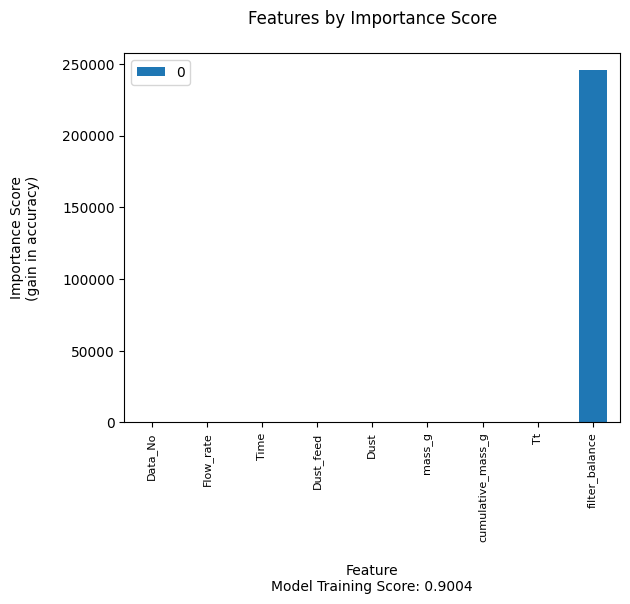

In [99]:
import matplotlib.pyplot as plt

# Rename Axis
f_importance = xbg_reg.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(data=f_importance, orient='index')
c_heading = X_train.transpose().reset_index().rename(columns={'index':'Variable'})
v_heading = c_heading['Variable'].to_list()
importance_df['Variable'] = v_heading

# Plot Most Important Feature
plot_importance = importance_df.set_index('Variable', drop=True).rename_axis(None)
plot_importance.plot.bar()

# plt.legend()
plt.xticks(fontsize=8)
plt.title('Features by Importance Score\n')
plt.ylabel('Importance Score\n(gain in accuracy)\n')
plt.xlabel('\nFeature\nModel Training Score: %.4f' % training_score)
plt.show()

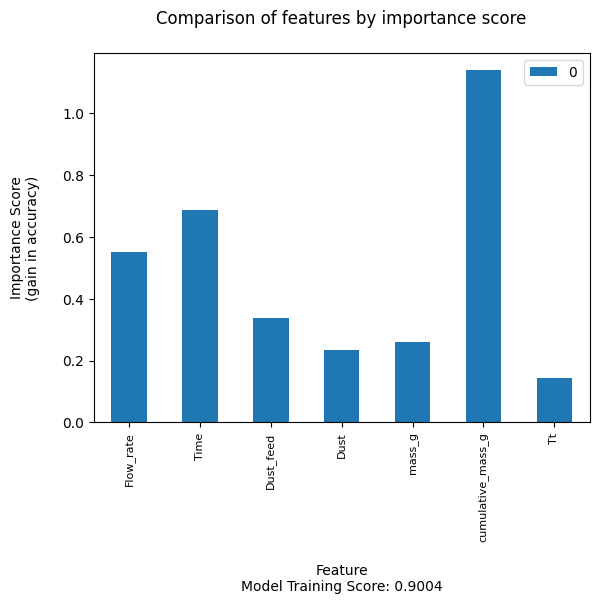

In [97]:
plot_importance = plot_importance.drop(['Data_No', 'filter_balance'], axis=0)
plot_importance.plot.bar()

# plt.legend()
plt.xticks(fontsize=8)
plt.title('Features by Importance Score\n')
plt.ylabel('Importance Score\n(gain in accuracy)\n')
plt.xlabel('\nFeature\nModel Training Score: %.4f' % training_score)
plt.show()

In [63]:
# from sklearn import datasets
# from sklearn.model_selection import train_test_split

# X, y = datasets.load_diabetes(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.preprocessing import MinMaxScaler

X_test_drop = X_test.drop(['RUL', 'filter_balance'], axis=1)
X_train_drop = X_train.drop('filter_balance', axis=1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_drop)
X_test_scaled = scaler.transform(X_test_drop)

print(X_train_scaled.shape)

(20931, 8)


---

In [64]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(
    base_score=0.5,
    booster='gblinear',
    eval_metric='rmse',
    max_depth=2,
    n_estimators=50,
    objective='reg:squarederror',
    verbosity = 0,
    )

xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=-1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, num_parallel_tree=None, predictor=None,
             random_state=0, ...)

In [65]:
# xgbr.fit(X_train, y_train)

Create comparison dataframe and Visualize it

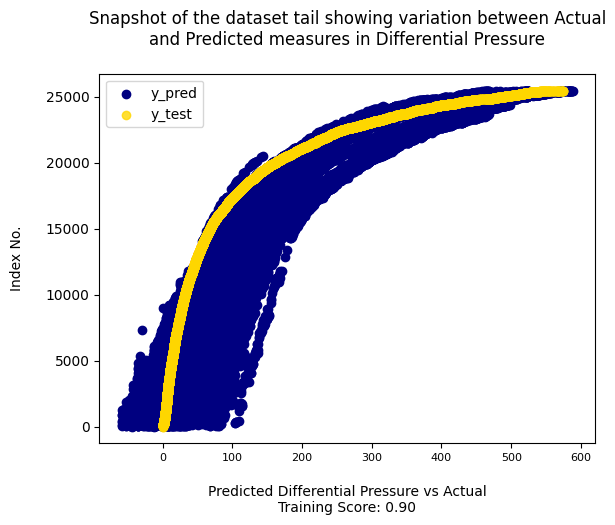

In [66]:
import matplotlib.pyplot as plt

X_test_drop = X_test.drop('RUL', axis=1)
y_pred = xgbr.predict(X_test_drop)

# Create Dataframe
y_test_df = pd.DataFrame(columns=['y_test'])
y_test_df['y_test'] = y_test
df_pred = pd.DataFrame(y_pred, columns=['y_pred'])
df_comp = y_test_df.reset_index(drop=True)
df_comp['y_pred'] = df_pred.y_pred.reset_index(drop=True)
df_comp['variance'] = ((df_comp.y_pred - df_comp.y_test)/sum(y_test,y_pred))*100

# Visualize it
# sample = df_comp.sort_values(by='y_test').tail(40)
sample = df_comp.sort_values(by='y_test')
my_range = range(1,len(sample.index)+1)
training_score = xgbr.score(X_train, y_train) 

# plt.hlines(y=my_range, xmin=sample['y_pred'], xmax=sample['y_test'], color='grey')
plt.scatter(sample['y_pred'], my_range, color='navy', alpha=1, label='y_pred')
plt.scatter(sample['y_test'], my_range, color='gold', alpha=0.8 , label='y_test')
plt.legend()

plt.xticks(fontsize=8)
# plt.yticks(my_range, sample.index, fontsize=0)
# set(gca,'ytick',[])
plt.title('Snapshot of the dataset tail showing variation between Actual\nand Predicted measures in Differential Pressure\n')
plt.ylabel('Index No.\n')
# plt.xlabel('\nPredicted Differential Pressure vs Actual\nAverage Variation in Pascals: %.8f' % df_comp.variance.mean())
plt.xlabel('\nPredicted Differential Pressure vs Actual\nTraining Score: %.2f' % training_score)
# plt.figure(figsize=(15,15))
plt.show()


## Evaluate Regressor, Train and Test Set Performance
Compute a performance metric on the data held out for testing, **df_test**
* [R² score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) (also called Coefficient of Determination)
* [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) (MAE)
* [Median Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html) (MdAE)
* [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (MSE)
* Root Mean Squared Error (RMSE).

We could also consider:
* Almost Correct Predictions Error Rate (ACPER)
* Mean Absolute Percentage Error (MAPE) and 
* Adjusted R² Score 
    * _((1 - R²) * (sample_size - 1)) * -1 / (sample_size - no_independent_features - 1))_

In [88]:
optimal_model_summary.T

,0
estimator,XGBRegressor
min_score,0.192148
mean_score (R²),0.83843
max_score,1.0
stdDev_score,0.323141
model__base_score,0.5
model__booster,gblinear
model__eval_metric,rmse
model__learning_rate,0.3
model__max_depth,2


* R2 Score: -0.107
* Mean Absolute Error: 97.403
* Median Absolute Error: 85.597
* Mean Squared Error: 16560.575
* Root Mean Squared Error: 128.688

In [ ]:
df_stop

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    # sample_size = len(X)
    # no_indep_features = y.shape[1]
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    # print('Adjusted R2 Score:', -(1 - R2)*(sample_size - 1)/(sample_size - no_indep_features - 1))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Median Absolute Error:', median_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()


def regression_variation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

    # # Visualize it
    # sample = df_comp.sort_values(by='y_test').tail(40)
    # my_range = range(1,len(sample.index)+1)

    # plt.hlines(y=my_range, xmin=sample['y_pred'], xmax=sample['y_test'], color='grey')
    # plt.scatter(sample['y_pred'], my_range, color='navy', alpha=1, label='y_pred')
    # plt.scatter(sample['y_test'], my_range, color='gold', alpha=0.8 , label='y_test')
    # plt.legend()

    # plt.xticks(fontsize=8)
    # plt.yticks(my_range, sample.index, fontsize=5)
    # plt.title('Snapshot of the dataset tail showing variation between Actual\nand Predicted measures in Differential Pressure\n')
    # plt.ylabel('Index No.\n')
    # plt.xlabel('\nPredicted Differential Pressure vs Actual\nAverage Variation in Pascals: %.8f' % df_comp.variance.mean())
    # # plt.figure(figsize=(15,15))
    # plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.127
Mean Absolute Error: 89.901
Median Absolute Error: 72.95
Mean Squared Error: 14308.034
Root Mean Squared Error: 119.616


* Test Set
R2 Score: -0.107
Mean Absolute Error: 97.403
Median Absolute Error: 85.597
Mean Squared Error: 16560.575
Root Mean Squared Error: 128.688




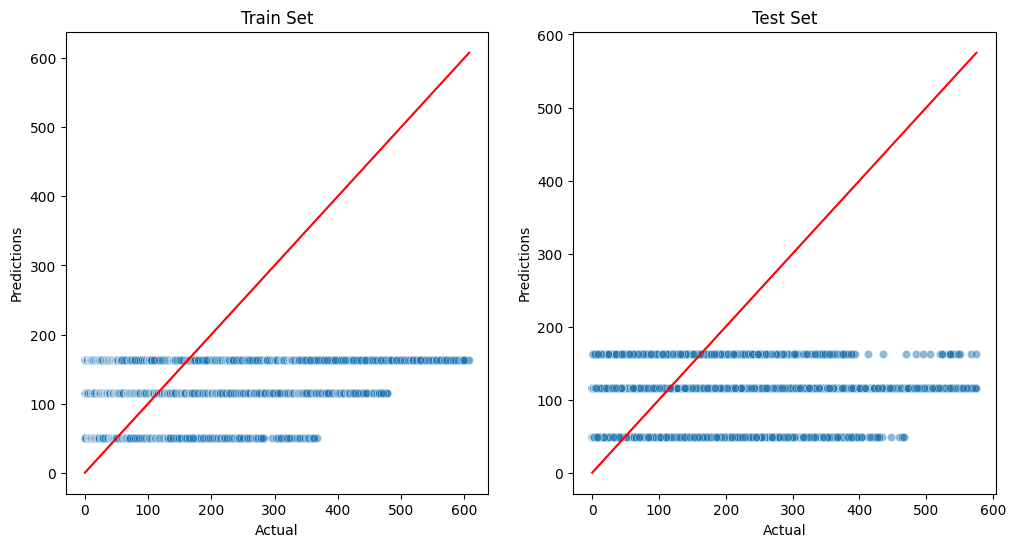

In [90]:
X_test_less_RUL = X_test.drop(labels=['RUL'], axis=1)
regression_performance(X_train, y_train, X_test_less_RUL, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test_less_RUL, y_test, best_regressor_pipeline)

### Observations

The **R2 score** (pipeline performance) is perfect 1.0 on the **df_train** and **df_test** sets respectively
* As the business requirement requests an R2 score of 0.7 or above, this is an exceptional result.

We also note that
* The predictions follow the actual values extremely well, (the blue dots follow along the red diagonal almost perfectly).
● We could have added more hyperparameters in the extensive search or considered more algorithms.
● The reason we selected fewer hyperparameter combinations in the notebook was to train all possible
models more quickly.
In your project you may want to consider more hyperparameters.
● If your hyperparameter combination almost reaches your performance criteria,
○ then you may want to add a few more hyperparameters with the expectation that it would reach the performance we stated in the business case.
● However, in this example, as our performance is very low, we'll explore other strategies. ○ We fitted a regressor pipeline using all available data.
 
■ However, it didn't meet our performance requirements
● What should we do?
● Does this mean the data doesn't have patterns to predict tenure properly for a prospect that will likely
churn?
● Is there any other strategy we could take, like before delivering this pipeline as our solution?
One strategy is to replace the feature selection step for a PCA (Principal Component Analysis) step. Next to refit our ML Pipeline with a PCA.

## Train the Model

Multiple regression and classification models under consideration 

* sklearn.linear_model.**LinearRegression**(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
* sklearn.linear_model.**LogisticRegression**(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
    * *.predict_proba(X)*
* sklearn.linear_model.**SGDRegressor**(*, fit_intercept=True, copy_X=True, n_jobs=None, positive=False)
    * *.SGDClassifier()*

List full of available and under consideration can be seen at scikitlearn [linear models](https://scikit-learn.org/stable/modules/linear_model.html#)

* No one optimal model. the most appropriate seems .LogisticRegression()
<!-- 
**.LinearRegression()** - Ordinary Least Squares
**.SGDClassifier()** and **.SGDRegressor()** - Stochastic Gradient Descent - SGD
.Ridge() 
.Lasso()
.MultiTaskLasso()
.ElasticNet()
.MultiTaskElasticNet()
.Lars() - Least Angle Regression
.LassoLars()
.OrthogonalMatchingPursuit() and orthogonal_mp()
.BayesianRidge() - Bayesian Regression
.ARDRegression() - Automatic Relevance Determination
Generalized Linear Models
**.LogisticRegression()** + **.predict_proba(X)**
.TweedieRegressor()
.Perceptron()
.PassiveAggressiveClassifier() and .PassiveAggressiveRegressor()
Robustness regression: outliers and modeling errors
.RANSACRegressor()
.TheilSenRegressor() and 
.HuberRegressor()
.QuantileRegressor()
Polynomial regression: extending linear models with basis functions
.PolynomialFeatures() transformer -->


Models with **R² score** = 1.0

In [ ]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)

print('Intercept :', linreg.intercept_)
print('Coefficients :\n', linreg.coef_)
linreg

In [ ]:
from sklearn.linear_model import SGDRegressor
SGDreg = SGDRegressor()
SGDreg.fit(X_train,y_train)
print('Intercept :', SGDreg.intercept_)
print('Coefficients :\n', SGDreg.coef_)
SGDreg

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
XTRreg = ExtraTreesRegressor()
XTRreg.fit(X_train,y_train)

Subsequent Models

In [ ]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor()
RFreg.fit(X_train,y_train)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
DTreg = DecisionTreeRegressor()
DTreg.fit(X_train,y_train)

In [ ]:
from xgboost import XGBRegressor
XGBreg = XGBRegressor()
XGBreg.fit(X_train,y_train)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
GBreg = GradientBoostingRegressor()
GBreg.fit(X_train,y_train)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ABreg = AdaBoostRegressor()
ABreg.fit(X_train,y_train)

### Predictions and Model Evaluation
* A good metric for this is the **coefficient of determination** also called **r2-score**.
* A good metric for this is the **median_absolute_error**.
* Consider Cross validation

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

from sklearn.metrics import r2_score
prediction_linear = linreg.predict(X_test)
prediction_SGDreg = SGDreg.predict(X_test)
prediction_XTRreg = XTRreg.predict(X_test)
prediction_RFreg = RFreg.predict(X_test)
prediction_DTreg = DTreg.predict(X_test)
prediction_XGBreg = XGBreg.predict(X_test)
prediction_GBreg = GBreg.predict(X_test)
prediction_ABreg = ABreg.predict(X_test)

print('prediction_linreg :', r2_score(y_test,prediction_linear))
print('prediction_SGDreg :', round(r2_score(y_test,prediction_SGDreg)))
print('prediction_XTRreg :', r2_score(y_test,prediction_XTRreg))
print('prediction_RFreg :', r2_score(y_test,prediction_RFreg))
print('prediction_DTreg :', r2_score(y_test,prediction_DTreg))
print('prediction_XGBreg :', r2_score(y_test,prediction_XGBreg))
print('prediction_GBreg :', r2_score(y_test,prediction_GBreg))
print('prediction_ABreg :', r2_score(y_test,prediction_ABreg))


In [ ]:
# from sklearn.metrics import classification_report

# prediction = linreg.predict(X_test)
# print(classification_report(y_test,prediction))

---

## Save Datasets 
Save the files to **/models** folder

In [ ]:
import os
try:
  os.makedirs(name='outputs/datasets/models/RULRegressor')
except Exception as e:
  print(e)

grid_search_summary.to_csv(f'outputs/datasets/models/RULRegressor/GS_summary.csv',index=False)
grid_search_pipelines.to_csv(f'outputs/datasets/models/RULRegressor/GS_pipelines.csv',index=False)
# linreg.to_csv(f'outputs/datasets/models/RULRegressor/RUL_linreg.csv',index=False)
# ABreg.to_csv(f'outputs/datasets/models/RULRegressor/RUL_ABreg.csv',index=False)

df_total.to_csv(f'outputs/datasets/models/df_total.csv',index=False)
df_total_model.to_csv(f'outputs/datasets/models/df_total_model.csv',index=False)
df_train.to_csv(f'outputs/datasets/models/df_train.csv',index=False)
df_train_even_dist.to_csv(f'outputs/datasets/models/df_train_even_dist.csv',index=False)
df_test.to_csv(f'outputs/datasets/models/df_test.csv',index=False)